In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse

df = pd.read_csv('01_01_18_to_13_03_23.csv')
df = df[['Date', 'Price']]
df = df.set_index('Date', drop = True)
df = df.iloc[::-1]
df.index = pd.to_datetime(df.index, format="%d/%m/%Y")
df

,Price
Date,
2018-01-02,21.37
2018-01-03,21.15
2018-01-04,20.97
2018-01-05,21.11
2018-01-08,22.43
...,...
2023-03-07,187.71
2023-03-08,182.00
2023-03-09,172.92


In [2]:
# Inference
test_data = df.tail(365)
test_data

,Price
Date,
2021-09-29,260.44
2021-09-30,258.49
2021-10-01,258.41
2021-10-04,260.51
2021-10-05,260.20
...,...
2023-03-07,187.71
2023-03-08,182.00
2023-03-09,172.92


In [3]:
df = df.iloc[:-365]
df

,Price
Date,
2018-01-02,21.37
2018-01-03,21.15
2018-01-04,20.97
2018-01-05,21.11
2018-01-08,22.43
...,...
2021-09-22,250.65
2021-09-23,251.21
2021-09-24,258.13


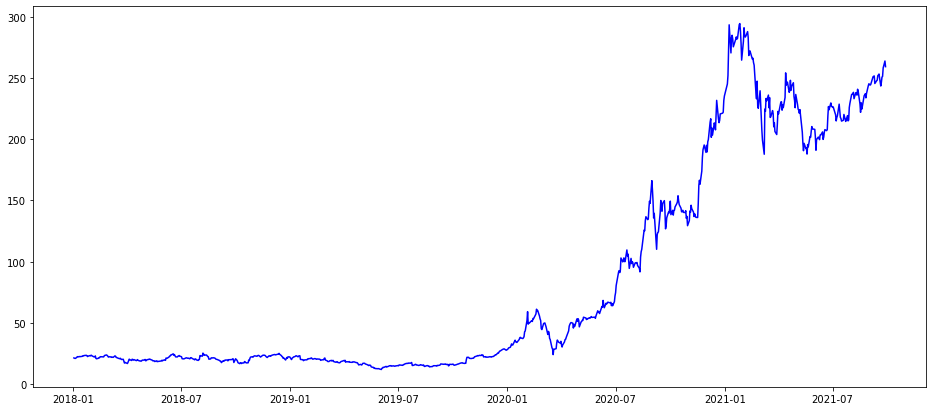

In [4]:
plt.figure(figsize=(16, 7))
plt.plot(df.loc['2018-01-02':'2023-03-13','Price'],
        label='Predicted', linestyle='-',  c='b')

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

# Prepare data for LSTM model by incoorporating timesteps of 60
def prepare_data(data):
    x_train = []
    y_train = []
    for i in range(60,len(data)):
        x_train.append(data[i-60:i,0])
        y_train.append(data[i,0])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
    
    return x_train, y_train

# Build and train LSTM model
def train_model(x_train,y_train):
    model = Sequential()
    n_neurons = x_train.shape[1] * x_train.shape[2]
    model.add(LSTM(n_neurons,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
    model.add(LSTM(n_neurons,return_sequences=False))
    model.add(Dense(5))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(x_train,y_train,epochs=500,batch_size=10,validation_split=0.2)
    
    return model

# Make prediction
def make_prediction(data,x_test_data):
    x_train, y_train = prepare_data(data)
    LSTM_model = train_model(x_train,y_train)
    forecast = LSTM_model.predict(x_test_data)
    #forecast = scaler.inverse_transform(forecast)
    return forecast

# Plot predictions and actual closing price 
def plot_predictions(total_data,test_data,forecast_data,title):
    test_data['Prediction']= forecast_data
    total_data.index = pd.to_datetime(total_data.index)
    test_data.index = pd.to_datetime(test_data.index)
    plt.figure(figsize=(16, 7))
    plt.plot(total_data.loc['2021-09-29':'2023-03-13', 'Price'],
             label='Actual', linestyle='-',  c='r')
    plt.plot(test_data.loc['2021-09-29':'2023-03-13', 'Prediction'],
             label='Predicted', linestyle='-',  c='b')
    
    plt.xlabel('Date',fontsize = '18')
    plt.ylabel('Stock Price',fontsize = '18')
    plt.title('Stock Prediction '+title,fontsize = '20')

    plt.grid()
    plt.legend()
    plt.savefig('Stock Prediction '+title+'.png',
                bbox_inches ="tight",
                pad_inches = 0.5,
                transparent = True,
                facecolor ="w",
                edgecolor ='w',
                orientation ='landscape')

In [ ]:
from sklearn import preprocessing

# Prepare test data
hist_data = pd.DataFrame(df['Price'])
#hist_data.index = hist_data.index.strftime('%Y-%m-%d')
dataset_total = pd.concat((hist_data, test_data), axis = 0)
inputs = dataset_total.iloc[len(dataset_total) - len(test_data) - 60:].values
inputs = inputs.reshape(-1,1)
#scaler = preprocessing.MinMaxScaler()
#inputs = scaler.fit_transform(inputs)
x_test, y_test = prepare_data(inputs)

# LSTM Model 
train = df.values
forecast = make_prediction(train,x_test)
plot_predictions(dataset_total,test_data,forecast,'Prediction')



Epoch 1/500
71/71 [==============================] - 5s 33ms/step - loss: 4743.7573 - val_loss: 45638.3125
Epoch 2/500
71/71 [==============================] - 2s 24ms/step - loss: 3685.7805 - val_loss: 39987.8750
Epoch 3/500
71/71 [==============================] - 2s 25ms/step - loss: 3261.1748 - val_loss: 36175.6562
Epoch 4/500
71/71 [==============================] - 2s 25ms/step - loss: 2759.0920 - val_loss: 31478.7520
Epoch 5/500
71/71 [==============================] - 2s 24ms/step - loss: 1963.2817 - val_loss: 25036.3848
Epoch 6/500
71/71 [==============================] - 2s 24ms/step - loss: 1344.1072 - val_loss: 19011.3398
Epoch 7/500
71/71 [==============================] - 2s 26ms/step - loss: 901.1089 - val_loss: 14481.3203
Epoch 8/500
71/71 [==============================] - 2s 25ms/step - loss: 633.0322 - val_loss: 11168.6387
Epoch 9/500
71/71 [==============================] - 2s 25ms/step - loss: 483.0468 - val_loss: 9396.9639
Epoch 10/500
71/71 [=====================

71/71 [==============================] - 2s 30ms/step - loss: 19.8905 - val_loss: 146.5071
Epoch 80/500
71/71 [==============================] - 2s 31ms/step - loss: 22.5103 - val_loss: 294.6705
Epoch 81/500
71/71 [==============================] - 2s 26ms/step - loss: 19.0427 - val_loss: 95.8687
Epoch 82/500
71/71 [==============================] - 2s 25ms/step - loss: 15.5734 - val_loss: 890.9092
Epoch 83/500
71/71 [==============================] - 2s 26ms/step - loss: 26.2784 - val_loss: 89.4798
Epoch 84/500
71/71 [==============================] - 2s 26ms/step - loss: 13.2972 - val_loss: 646.8080
Epoch 85/500
71/71 [==============================] - 2s 26ms/step - loss: 13.9630 - val_loss: 160.3684
Epoch 86/500
71/71 [==============================] - 2s 27ms/step - loss: 13.5304 - val_loss: 132.5084
Epoch 87/500
71/71 [==============================] - 2s 27ms/step - loss: 20.7436 - val_loss: 397.4784
Epoch 88/500
71/71 [==============================] - 3s 36ms/step - loss: 13.9

71/71 [==============================] - 2s 27ms/step - loss: 15.2127 - val_loss: 278.7744
Epoch 158/500
71/71 [==============================] - 2s 27ms/step - loss: 15.3005 - val_loss: 201.7086
Epoch 159/500
71/71 [==============================] - 2s 26ms/step - loss: 13.6727 - val_loss: 218.7806
Epoch 160/500
71/71 [==============================] - 2s 27ms/step - loss: 13.8109 - val_loss: 123.7663
Epoch 161/500
71/71 [==============================] - 2s 27ms/step - loss: 11.8817 - val_loss: 441.3861
Epoch 162/500
71/71 [==============================] - 2s 27ms/step - loss: 12.7686 - val_loss: 196.2412
Epoch 163/500
71/71 [==============================] - 2s 28ms/step - loss: 21.8932 - val_loss: 137.5714
Epoch 164/500
71/71 [==============================] - 2s 27ms/step - loss: 20.9527 - val_loss: 167.1400
Epoch 165/500
71/71 [==============================] - 2s 27ms/step - loss: 16.5731 - val_loss: 255.8410
Epoch 166/500
71/71 [==============================] - 2s 27ms/step -

71/71 [==============================] - 2s 27ms/step - loss: 15.3827 - val_loss: 172.8776
Epoch 236/500
71/71 [==============================] - 2s 28ms/step - loss: 19.1774 - val_loss: 584.4877
Epoch 237/500
71/71 [==============================] - 2s 33ms/step - loss: 21.2937 - val_loss: 188.7737
Epoch 238/500
71/71 [==============================] - 2s 30ms/step - loss: 11.7599 - val_loss: 215.8613
Epoch 239/500
71/71 [==============================] - 2s 30ms/step - loss: 11.4984 - val_loss: 192.1855
Epoch 240/500
71/71 [==============================] - 2s 28ms/step - loss: 12.6757 - val_loss: 143.0276
Epoch 241/500
71/71 [==============================] - 2s 28ms/step - loss: 12.1828 - val_loss: 146.9221
Epoch 242/500
71/71 [==============================] - 2s 28ms/step - loss: 12.6120 - val_loss: 105.7410
Epoch 243/500
71/71 [==============================] - 2s 27ms/step - loss: 13.7110 - val_loss: 141.3537
Epoch 244/500
71/71 [==============================] - 2s 26ms/step -

71/71 [==============================] - 3s 36ms/step - loss: 10.8229 - val_loss: 141.0703
Epoch 314/500
71/71 [==============================] - 2s 31ms/step - loss: 11.0228 - val_loss: 453.2163
Epoch 315/500
71/71 [==============================] - 2s 35ms/step - loss: 13.6852 - val_loss: 189.5922
Epoch 316/500
71/71 [==============================] - 2s 35ms/step - loss: 10.7022 - val_loss: 178.2518
Epoch 317/500
71/71 [==============================] - 2s 33ms/step - loss: 9.1383 - val_loss: 284.3511
Epoch 318/500
71/71 [==============================] - 2s 30ms/step - loss: 10.9831 - val_loss: 198.4656
Epoch 319/500
71/71 [==============================] - 2s 34ms/step - loss: 12.4546 - val_loss: 290.3827
Epoch 320/500
71/71 [==============================] - 2s 32ms/step - loss: 15.3982 - val_loss: 294.4445
Epoch 321/500
71/71 [==============================] - 2s 29ms/step - loss: 11.9851 - val_loss: 638.8043
Epoch 322/500
71/71 [==============================] - 2s 33ms/step - 

In [ ]:
print("Root Mean Squared Error between actual and  predicted values: ",rmse(test_data['Prediction'],test_data['Price']))